# PETITE BSM shower generation example

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers. 

Authors: Kevin J. Kelly (Texas A&M), Nikita Blinov (U. Victoria), Ryan Plestid (Caltech), Patrick J. Fox (Fermilab), and Pedro A.M. Machado (Fermilab)

It includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Feb13_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts_neval.pkl

You can check versions with the code below and adjust if necessary

In [1]:
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

dictionary_dir = "lightmasses_fine/"

Python version:  3.10.11
Numpy version:  1.25.2
PETITE home directory: /Users/kjkelly/Library/CloudStorage/Dropbox/GitHub/PETITE/


### Load in dependencies and set font styles

In [2]:
#from kjkutils import *
from PETITE.dark_shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

####  Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

In [3]:
sGraphite = DarkShower(PETITE_home_dir+"lightmasses_fine/", "graphite", 0.030, 0.0323)

In [4]:
print(sGraphite._mV_list)
print(sGraphite._mV)
print(sGraphite._mV_estimator)

[0.003000000000000001, 0.0036009876736276714, 0.004322370741872809, 0.005188267920777629, 0.006227629610066035, 0.007475205820588828, 0.008972708005923404, 0.01077020364279683, 0.012927790186723739, 0.01551760436987898, 0.018626234020055036, 0.02235761303744086, 0.026836496319853947, 0.03221263081704946, 0.03866576216910467, 0.046411644320788356, 0.05570925303731685, 0.06686944449812761, 0.08026534846002908, 0.09634484347466486, 0.11564553125661849, 0.13881271085506888, 0.16662095357731505, 0.20000000000000004]
0.03221263081704946
0.03221263081704946


In [5]:
sGraphite._loaded_dark_samples['DarkBrem'][10][1]['max_F']

{'graphite': 0.005304193527379386,
 'lead': 0.9402879259297763,
 'iron': 0.09777737937204015}

In [6]:
list(sGraphite.draw_dark_sample(20.0, 50, "DarkBrem"))

[0.8637201573808002, -5.483577430786848, -6.655602777321394]

In [7]:
p0 = pickle.load(open(PETITE_home_dir+"lightmasses_fine/dark_xsec.pkl", "rb"))[sGraphite._mV_estimator]['DarkBrem']['graphite']

Text(0, 0.5, '$\\sigma_{\\rm dark\\ brem.}\\ [\\mathrm{GeV}^{-2}]$')

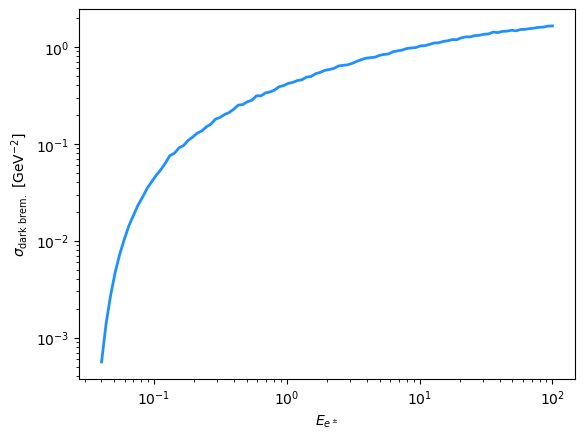

In [8]:
sX, sY = np.transpose(p0)
plt.plot(sX, sY, lw=2, color='dodgerblue')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^\pm}$")
plt.gca().set_ylabel(r"$\sigma_{\rm dark\ brem.}\ [\mathrm{GeV}^{-2}]$")

In [11]:
ntrials = []
xs = []
for k in tqdm(range(100000)):
    s0 = sGraphite.draw_dark_sample(1.0, process="DarkAnn", VB=True)
    xs.append([s0[0], s0[1]])
    ntrials.append(s0[-1])

  0%|          | 0/100000 [00:03<?, ?it/s]


Exception: ('No Sample Found', 'DarkAnn', 1.0, 1)

In [8]:
np.max(ntrials)

2.0

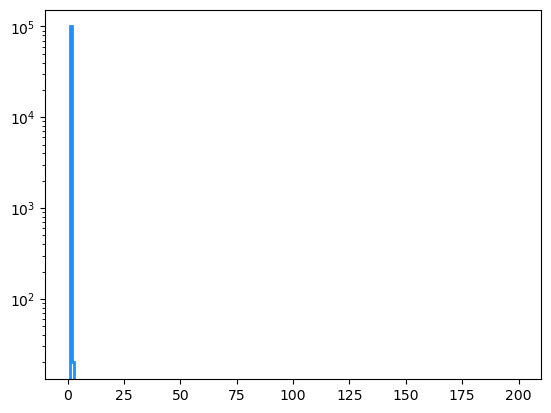

In [9]:
plt.hist(ntrials, bins=np.linspace(0, 200, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

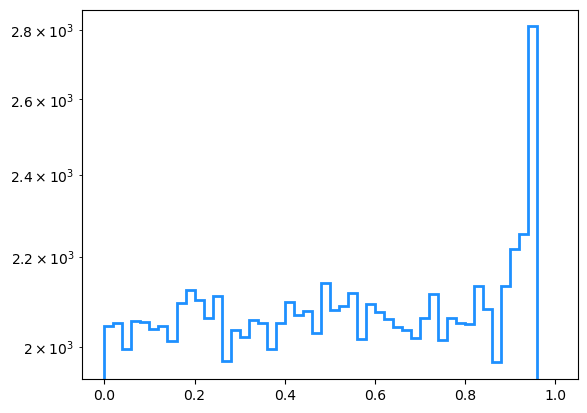

In [11]:
plt.hist(np.transpose(xs)[0], bins=np.linspace(0, 1, 51), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

In [12]:
import numpy as np

In [14]:
s_test = 2.0*0.000511*(0.000511 + 1.0)
alpha_test = 1/137.0
beta = (2.*alpha_test/np.pi)*(np.log(s_test/0.000511**2) - 1.)

x_array = 1 - np.power(np.transpose(xs)[0], 2./beta)

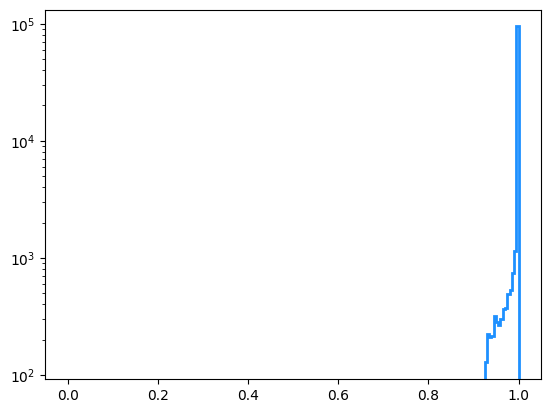

In [15]:
plt.hist(x_array, bins=np.linspace(0, 1, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

/var/folders/8n/m3w03969119_28y6ndzhqp480000gp/T/ipykernel_22178/2871372156.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.gca().set_yscale('log')


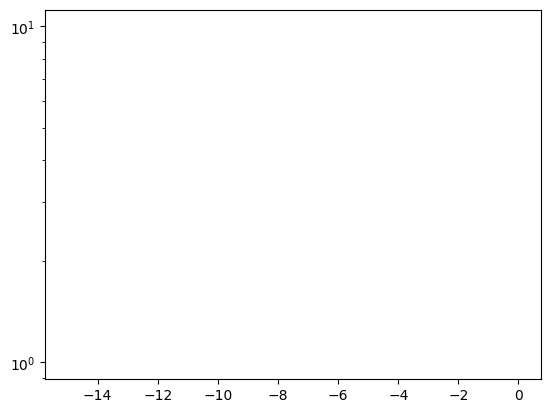

In [13]:
plt.hist(np.transpose(xs)[1], bins=np.linspace(-15,0, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

In [13]:
sGraphite._mV_estimator

0.03

In [5]:
(0.030**2 - 2*m_electron**2)/(2*m_electron)

0.8801170336516327

In [10]:
sGraphite.get_DarkBremXSec()

[[0.04026578852131182, 0.0005626689762698138],
 [0.04357423606827969, 0.001401837933194776],
 [0.04715452295015201, 0.002753724639012437],
 [0.05102898490686491, 0.004748904765155152],
 [0.0552217928994371, 0.0073003667782822025],
 [0.059759103901321796, 0.010375259298627698],
 [0.06466922407956396, 0.01427055241558186],
 [0.069982785383774, 0.01827438185693094],
 [0.07573293664457398, 0.02327059616824074],
 [0.08195555037369041, 0.02821550645181562],
 [0.0886894465558234, 0.034648352163904335],
 [0.09597663482842478, 0.04064163600278438],
 [0.1038625765602319, 0.047399043362540354],
 [0.11239646846354302, 0.05398615753135241],
 [0.12163154950955912, 0.06322992472364876],
 [0.13162543306149335, 0.07556984165451859],
 [0.14244046629747215, 0.0799291853604224],
 [0.1541441191654994, 0.09079977831903434],
 [0.16680940529699284, 0.0959067055715609],
 [0.18051533750477525, 0.10842030091715284],
 [0.1953474207071606, 0.11741100896904809],
 [0.21139818535325794, 0.1287252941460282],
 [0.22876

In [4]:
sGraphite._minimum_calculable_dark_energy

{11: {'DarkBrem': 0.04026578852131182},
 -11: {'DarkBrem': 0.04026578852131182, 'DarkAnn': 1.0148077058687917},
 22: {'DarkComp': 1.0476360887694047},
 111: {'TwoBody_BSMDecay': -1}}

In [12]:
Energies, Weights = {}, {}
parent_pid_options = [11, -11, 22]
for pr in dark_process_codes:
    Energies[pr] = {}
    Weights[pr] = {}
    for pid in parent_pid_options:
        Energies[pr][pid] = []
        Weights[pr][pid] = []

for kk in tqdm(range(1500)):
    p0 = [10, 0, 0, 10]
    r0 = [0, 0, 0]
    pdict = {"PID":22}
    part0 = Particle(p0, r0, pdict)
    s0SM = sGraphite.generate_shower(part0)
    s0BSM = sGraphite.generate_dark_shower(ExDir=list(s0SM));
    for p0 in s0BSM[1]:   
        genprocess = p0.get_ids()["generation_process"]
        parent_pid = p0.get_ids()["parent_PID"]

        Energies[genprocess][parent_pid].append(p0.get_p0()[0])
        Weights[genprocess][parent_pid].append(p0.get_ids()["weight"])

100%|██████████| 1500/1500 [31:41<00:00,  1.27s/it]


In [13]:
len(s0SM), len(s0BSM[1])

(419, 311)

In [14]:
log_bins_0 = np.logspace(-2, 2, 41)
def bin_width(energy, bins=log_bins_0):
    index = np.abs(bins - energy).argmin()
    return bins[index+1] - bins[index]

Text(0.5, 0, '$E_V\\ [\\mathrm{GeV}]$')

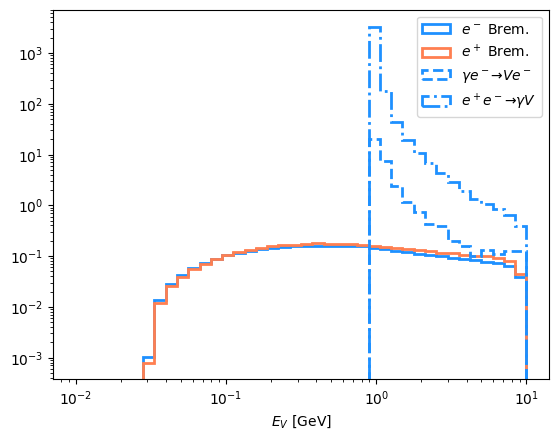

In [15]:
plt.hist(Energies['DarkBrem'][11], weights=Weights['DarkBrem'][11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")
plt.hist(Energies['DarkBrem'][-11], weights=Weights['DarkBrem'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")
plt.hist(Energies['DarkComp'][22], weights=Weights['DarkComp'][22], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")
plt.hist(Energies['DarkAnn'][-11], weights=Weights['DarkAnn'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")

In [11]:
plt.savefig("/Users/kjkelly/Dropbox/DarkVFlux.pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

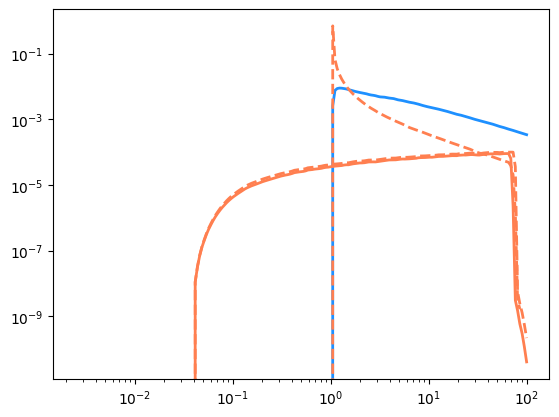

In [16]:
energyvec = np.logspace(-2.6, 2, 201)
plt.plot(energyvec, [sGraphite.GetBSMWeights([22, ee], "DarkComp") for ee in energyvec], lw=2, color='dodgerblue')
plt.plot(energyvec, [sGraphite.GetBSMWeights([11, ee], "DarkBrem") for ee in energyvec], lw=2, color='coral')
plt.plot(energyvec, [sGraphite.GetBSMWeights([-11, ee], "DarkBrem") for ee in energyvec], lw=2, ls='--', color='coral')
plt.plot(energyvec, [sGraphite.GetBSMWeights([-11, ee], "DarkAnn") for ee in energyvec], lw=2, ls='--', color='coral')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [24]:
len(s0BSM[1])

368

In [25]:
s = np.array(s0BSM[1])
s[np.where(np.array([p0.get_ids()[-2] for p0 in s0BSM[1]]) == 1)[0]]

array([], dtype=object)